# Final Practical: Analysing Clickstream Data for Online Shopping
*Xiangyu Zhao, Trinity College*  
*CRSid: xz398*

# 1  Data Exploration

First, import a few common modules and add utility functions:

In [1]:
# A few common imports
import os
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def load_data(path, file):
    csv_path = os.path.join(path, file)
    return pd.read_csv(csv_path, sep=';')

Now, run `load_data` to load the "e-shop clothing 2008" dataset, and get a general overview of the attributes and their value distributions:

In [3]:
eshop = load_data('e-shop data and description', 'e-shop clothing 2008.csv')
eshop.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [4]:
eshop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

Now I will add a `date` attribute that merges the `year`, `month` and `day` attributes, then encode the datetime attribute `date` and the textual `page 2 (clothing model)` attribute into numerical values, so that they can show up in the data distribution summary table and histograms later on: 

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
page_2_encoded = encoder.fit_transform(eshop['page 2 (clothing model)'])
page_2_encoded

array([ 4,  7, 70, ..., 11, 87, 53])

In [6]:
eshop['date'] = pd.to_datetime(eshop[['year', 'month', 'day']])
date_encoded = encoder.fit_transform(eshop['date'])
date_encoded

array([  0,   0,   0, ..., 134, 134, 134], dtype=int64)

In [7]:
eshop['page 2 (clothing model)'] = page_2_encoded.astype(np.int64)
eshop['date'] = date_encoded
eshop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   year                     165474 non-null  int64
 1   month                    165474 non-null  int64
 2   day                      165474 non-null  int64
 3   order                    165474 non-null  int64
 4   country                  165474 non-null  int64
 5   session ID               165474 non-null  int64
 6   page 1 (main category)   165474 non-null  int64
 7   page 2 (clothing model)  165474 non-null  int64
 8   colour                   165474 non-null  int64
 9   location                 165474 non-null  int64
 10  model photography        165474 non-null  int64
 11  price                    165474 non-null  int64
 12  price 2                  165474 non-null  int64
 13  page                     165474 non-null  int64
 14  date                     165474 non-

In [8]:
eshop.describe()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page,date
count,165474.0,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000,165474.000000
mean,2008.0,5.585887,14.524554,9.817476,26.952621,12058.417056,2.400842,82.742945,6.227655,3.258198,1.260071,43.802507,1.488167,1.710166,61.679907
std,0.0,1.328160,8.830374,13.478411,7.150691,7008.418903,1.144420,59.116265,4.235606,1.713206,0.438674,12.548131,0.499861,0.982412,40.733745
min,2008.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,0.000000
25%,2008.0,4.000000,7.000000,2.000000,29.000000,5931.000000,1.000000,38.000000,3.000000,2.000000,1.000000,33.000000,1.000000,1.000000,24.000000
50%,2008.0,5.000000,14.000000,6.000000,29.000000,11967.500000,2.000000,70.000000,4.000000,3.000000,1.000000,43.000000,1.000000,1.000000,59.000000
75%,2008.0,7.000000,22.000000,12.000000,29.000000,18219.000000,3.000000,132.000000,9.000000,5.000000,2.000000,52.000000,2.000000,2.000000,98.000000
max,2008.0,8.000000,31.000000,195.000000,47.000000,24026.000000,4.000000,216.000000,14.000000,6.000000,2.000000,82.000000,2.000000,5.000000,134.000000


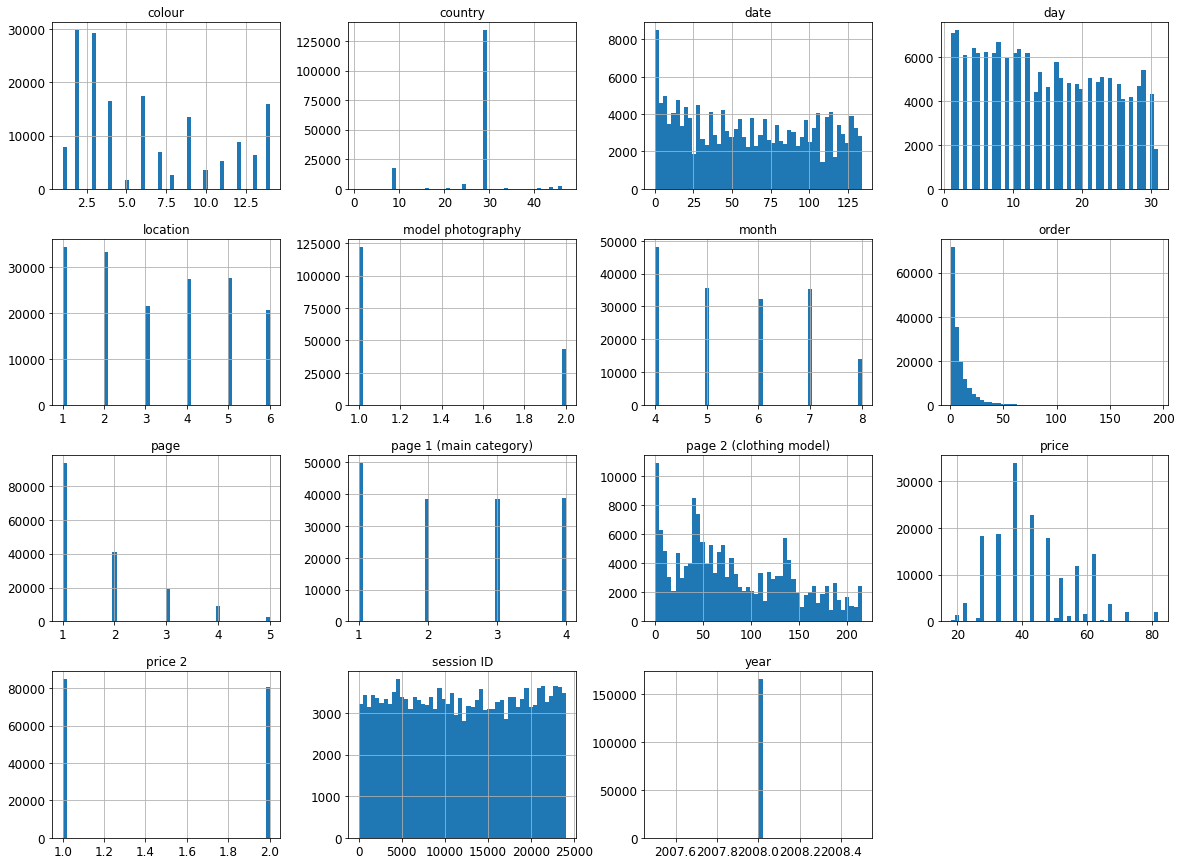

In [9]:
eshop.hist(bins=50, figsize=(20, 15))

plt.savefig('histogram.png')
plt.show()

According to the provided description of the data, the target value that I am required by the tasks to predict, `price 2`, is defined as "variable informing whether the price of a particular product is higher than the average price for the entire product category". Therefore, the following guesses can be made regarding to `price 2`:

**Guess 1:** The value of `price 2` is directly derived from the mean value of `price` on each main category (i.e., `page 1 (main category)`). Experimenting on this guess, I get:

In [10]:
category_mean_price = eshop.groupby('page 1 (main category)').mean()['price']
category_mean_price

page 1 (main category)
1    46.714889
2    51.192434
3    40.291728
4    36.233799
Name: price, dtype: float64

In [11]:
if np.all(eshop['price 2'].values == 
          np.where(eshop['price'].values > category_mean_price.take(eshop['page 1 (main category)'] - 1).values, 
                   1, 2).astype(np.int64)):
    print('Guess is correct')
else:
    print('Guess is wrong')

Guess is correct


**Guess 2:** The value of `price` is fixed for each clothing model (i.e., `page 2 (clothing model)`), and consequently the value of `price 2` is also fixed for each clothing model. Experimenting on this guess, I get:

In [12]:
model_mean_price = eshop.groupby('page 2 (clothing model)').mean()['price']
model_mean_price

page 2 (clothing model)
0      28.0
1      38.0
2      62.0
3      38.0
4      28.0
       ... 
212    28.0
213    28.0
214    43.0
215    48.0
216    23.0
Name: price, Length: 217, dtype: float64

In [13]:
if np.all(eshop['price'].values == model_mean_price.take(eshop['page 2 (clothing model)']).values.astype(np.int64)):
    print('Guess is correct')
else: 
    print('Guess is wrong')

Guess is correct


Therefore, I can derive the following conclusion: the target value `price 2` can be directly obtained from the clothing model, `page 2 (clothing model)`.

# 2 Machine Learning Algorithms Implementation

First remove the manually added `date` attribute, which contains duplicate information of the existing attributes `year`, `month` and `day`, and split the data into training, development, and test sets:

In [14]:
eshop = eshop.drop('date', axis=1)
eshop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   year                     165474 non-null  int64
 1   month                    165474 non-null  int64
 2   day                      165474 non-null  int64
 3   order                    165474 non-null  int64
 4   country                  165474 non-null  int64
 5   session ID               165474 non-null  int64
 6   page 1 (main category)   165474 non-null  int64
 7   page 2 (clothing model)  165474 non-null  int64
 8   colour                   165474 non-null  int64
 9   location                 165474 non-null  int64
 10  model photography        165474 non-null  int64
 11  price                    165474 non-null  int64
 12  price 2                  165474 non-null  int64
 13  page                     165474 non-null  int64
dtypes: int64(14)
memory usage: 17.7 MB


In [15]:
from sklearn.model_selection import train_test_split

data = eshop.columns.drop('price 2')
target = 'price 2'

X, y = eshop[data], eshop[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, train_size=0.9, random_state=42)

print('X_train shape:', X_train.shape)
print('X_dev.shape:', X_dev.shape)
print('X_test.shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_dev.shape:', y_dev.shape)
print('y_test.shape:', y_test.shape)

X_train shape: (134033, 13)
X_dev.shape: (14893, 13)
X_test.shape: (16548, 13)
y_train shape: (134033,)
y_dev.shape: (14893,)
y_test.shape: (16548,)


## 2.1 Trivial Classifier

Based on the insights gained from data exploration, I can trivially build a classifier that calculates the main price of each main category, and compares it with the `price` attribute, achieving 100% accuracy:

In [16]:
class TrivialClassifier:
    def __init__(self):
        self.mean_price = None
        
    def fit(self, X):
        self.mean_price = X.groupby('page 1 (main category)').mean()['price']
    
    def predict(self, X):
        return np.where(X['price'].values > self.mean_price.take(X['page 1 (main category)'] - 1).values, 
                        1, 2).astype(np.int64)

In [17]:
from sklearn.metrics import accuracy_score

trivial_classifier = TrivialClassifier()
trivial_classifier.fit(X_train)
y_train_pred = trivial_classifier.predict(X_train)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = trivial_classifier.predict(X_dev)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 1.0
Development set accuracy: 1.0


In [18]:
y_test_pred = trivial_classifier.predict(X_test)
print('Test set accuracy:', accuracy_score(y_test, y_test_pred))

Test set accuracy: 1.0


However, if in the scenario where the e-commerce website owner wishes to dynamically alter the website and the prices of the products based on the user and their behaviour to maximise profit, and requires a predictive model that attempts to generalise beyond this dataset, as some features of the e-commerce website from which the dataset was derived might be changed in the future, then such a trivial classifier will be unsuitable for this task, because it was built based on the assumption that `price` is fixed for each clothing model. Also, to build such a predictive model, I will have to interpret `price 2` as a user's willingness to pay a premium price, rather than its original definition "whether the price of a particular product is higher than the average price for the entire product category", and the attributes that directly derive `price 2`, i.e., `price` and `page 2 (clothing model)`, must be dropped when training the model.

## 2.2 Preparation

Before actually training any model, I need to figure out the baseline accuracy, which is a model that always predicts one class: 

In [19]:
eshop[target].value_counts() / eshop[target].count()

1    0.511833
2    0.488167
Name: price 2, dtype: float64

Therefore the baseline accuracy is 51.18%, obtained by a model that always predicts `1-yes`.

Now re-split the data into the training, development and test sets, dropping the `price` and `page 2 (clothing model)` attributes:

In [20]:
data_1 = eshop.columns.drop(['page 2 (clothing model)', 'price', 'price 2'])
target = 'price 2'

X_1, y = eshop[data_1], eshop[target]
X_train_1, X_test_1, y_train, y_test = train_test_split(X_1, y, test_size=0.1, train_size=0.9, random_state=42)
X_train_1, X_dev_1, y_train, y_dev = train_test_split(X_train_1, y_train, test_size=0.1, train_size=0.9, random_state=42)

print('X_train_1 shape:', X_train_1.shape)
print('X_dev_1.shape:', X_dev_1.shape)
print('X_test_1.shape:', X_test_1.shape)
print('y_train shape:', y_train.shape)
print('y_dev.shape:', y_dev.shape)
print('y_test.shape:', y_test.shape)

X_train_1 shape: (134033, 11)
X_dev_1.shape: (14893, 11)
X_test_1.shape: (16548, 11)
y_train shape: (134033,)
y_dev.shape: (14893,)
y_test.shape: (16548,)


I will also prepare a scaled dataset from the above dataset:

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_1_scaled = scaler.fit_transform(X_train_1.astype(np.float64))
X_dev_1_scaled = scaler.fit_transform(X_dev_1.astype(np.float64))
X_test_1_scaled = scaler.fit_transform(X_test_1.astype(np.float64))

Now I will prepare another dataset, trying dropping some more less-correlated features:  

- Since all records in this dataset are collected in 2008, I can drop the `year` feature;  
- The `month` feature also seems unimportant, but judging from the data distribution histogram for `day` and `date` attributes, there may be periodic rises and falls with durations of a few days, so I will drop the `month` feature, but keep the `day` feature;  
- The value of the `session ID` feature seems to be automatically generated and reveal no information of the customer, so I will also drop the `session ID` feature.

I will prepare both the unscaled and scaled datasets with those features dropped.

In [22]:
data_2 = eshop.columns.drop(['year', 'month', 'session ID', 'page 2 (clothing model)', 'price', 'price 2'])

X_2 = eshop[data_2]
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size=0.1, train_size=0.9, random_state=42)
X_train_2, X_dev_2, y_train, y_dev = train_test_split(X_train_2, y_train, test_size=0.1, train_size=0.9, random_state=42)

print('X_train shape:', X_train_2.shape)
print('X_dev.shape:', X_dev_2.shape)
print('X_test.shape:', X_test_2.shape)
print('y_train shape:', y_train.shape)
print('y_dev.shape:', y_dev.shape)
print('y_test.shape:', y_test.shape)

X_train shape: (134033, 8)
X_dev.shape: (14893, 8)
X_test.shape: (16548, 8)
y_train shape: (134033,)
y_dev.shape: (14893,)
y_test.shape: (16548,)


In [23]:
X_2_scaled = scaler.fit_transform(X_2.astype(np.float64))
X_train_2_scaled = scaler.fit_transform(X_train_2.astype(np.float64))
X_dev_2_scaled = scaler.fit_transform(X_dev_2.astype(np.float64))
X_test_2_scaled = scaler.fit_transform(X_test_2.astype(np.float64))

## 2.3 Traditional Models
### 2.3.1 Naïve Bayes

Now train 4 Gaussian Naïve Bayes models using both datasets, with and without scaling:

In [24]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb_1 = GaussianNB() 
gnb_1.fit(X_train_1, y_train)
y_train_pred = gnb_1.predict(X_train_1)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gnb_1.predict(X_dev_1)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.574015354427641
Development set accuracy: 0.5675149399046532


In [25]:
gnb_1_scaled = GaussianNB() 
gnb_1_scaled.fit(X_train_1_scaled, y_train)
y_train_pred = gnb_1_scaled.predict(X_train_1_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gnb_1_scaled.predict(X_dev_1_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5778502309132826
Development set accuracy: 0.5710736587658631


In [26]:
gnb_2 = GaussianNB() 
gnb_2.fit(X_train_2, y_train)
y_train_pred = gnb_2.predict(X_train_2)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gnb_2.predict(X_dev_2)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5779173785560272
Development set accuracy: 0.5703350567380648


In [27]:
gnb_2_scaled = GaussianNB() 
gnb_2_scaled.fit(X_train_2_scaled, y_train)
y_train_pred = gnb_2_scaled.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gnb_2_scaled.predict(X_dev_2_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5779173785560272
Development set accuracy: 0.5700664741825019


All 4 Gaussian Naïve Bayes models produce only barely-above-the-baseline accuracies, though there are some minor improvement from training using the second dataset, and from scaling.

Now try training 2 multinomial Naïve Bayes models using both datasets, without scaling. Since `MultinomialNB` does not accept negative values, I will not apply the scaled dataset on `MultinomialNB`:

In [28]:
mnb_1 = MultinomialNB() 
mnb_1.fit(X_train_1, y_train)
y_train_pred = mnb_1.predict(X_train_1)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = mnb_1.predict(X_dev_1)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5056292107167638
Development set accuracy: 0.5048009131806889


In [29]:
mnb_2 = MultinomialNB() 
mnb_2.fit(X_train_2, y_train)
y_train_pred = mnb_2.predict(X_train_2)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = mnb_2.predict(X_dev_2)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.542672326964255
Development set accuracy: 0.5401866648761163


The multinomial Naïve Bayes model trained using the second dataset produces only barely-above-the-baseline accuracies, and the model trained using the first dataset performs even worse than the baseline model. 

Now try training 4 Bernoulli Naïve Bayes model using both datasets, with and without scaling:

In [30]:
bnb_1 = BernoulliNB() 
bnb_1.fit(X_train_1, y_train)
y_train_pred = bnb_1.predict(X_train_1)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = bnb_1.predict(X_dev_1)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5116202726194296
Development set accuracy: 0.5134627005975961


In [31]:
bnb_1_scaled = BernoulliNB() 
bnb_1_scaled.fit(X_train_1_scaled, y_train)
y_train_pred = bnb_1_scaled.predict(X_train_1_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = bnb_1_scaled.predict(X_dev_1_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.547879999701566
Development set accuracy: 0.5426039078761834


In [32]:
bnb_2 = BernoulliNB() 
bnb_2.fit(X_train_2, y_train)
y_train_pred = bnb_2.predict(X_train_2)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = bnb_2.predict(X_dev_2)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5116202726194296
Development set accuracy: 0.5134627005975961


In [33]:
bnb_2_scaled = BernoulliNB() 
bnb_2_scaled.fit(X_train_2_scaled, y_train)
y_train_pred = bnb_2_scaled.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = bnb_2_scaled.predict(X_dev_2_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5446718345482082
Development set accuracy: 0.539985227959444


The Bernoulli Naïve Bayes models trained using scaled datasets produce only barely-above-the-baseline accuracies, and those models trained using unscaled datasets perform even worse than the baseline model. It seems that Naïve Bayes models perform poorly in this task.

### 2.3.2 Logistic Regression

Now train 4 logistic regression models using both datasets, with and without scaling:

In [34]:
from sklearn.linear_model import LogisticRegression

log_reg_1 = LogisticRegression(max_iter=200)  # Number of iterations is somewhere between 100-200 
log_reg_1.fit(X_train_1, y_train)
y_train_pred = log_reg_1.predict(X_train_1)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = log_reg_1.predict(X_dev_1)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5690389680153395
Development set accuracy: 0.5593903175988719


In [35]:
log_reg_1_scaled = LogisticRegression()
log_reg_1_scaled.fit(X_train_1_scaled, y_train)
y_train_pred = log_reg_1_scaled.predict(X_train_1_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = log_reg_1_scaled.predict(X_dev_1_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5663679840039393
Development set accuracy: 0.5544886859598469


In [36]:
log_reg_2 = LogisticRegression()
log_reg_2.fit(X_train_2, y_train)
y_train_pred = log_reg_2.predict(X_train_2)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = log_reg_2.predict(X_dev_2)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5626897853513687
Development set accuracy: 0.5515342778486537


In [37]:
log_reg_2_scaled = LogisticRegression()
log_reg_2_scaled.fit(X_train_2_scaled, y_train)
y_train_pred = log_reg_2_scaled.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = log_reg_2_scaled.predict(X_dev_2_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5626897853513687
Development set accuracy: 0.5518700060431075


All models produce only barely-above-the-baseline accuracies. It seems that Logistic Regression models also perform poorly in this task.

### 2.3.3 Single-Layer Perceptron

Now train 4 single-layer perceptron models using both datasets, with and without scaling:

In [38]:
from sklearn.linear_model import SGDClassifier

sgd_1 = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_1.fit(X_train_1, y_train)
y_train_pred = sgd_1.predict(X_train_1)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_1.predict(X_dev_1)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.48837972738057045
Development set accuracy: 0.4865372994024038


In [39]:
sgd_1_scaled = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_1_scaled.fit(X_train_1_scaled, y_train)
y_train_pred = sgd_1_scaled.predict(X_train_1_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_1_scaled.predict(X_dev_1_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.48936455947415936
Development set accuracy: 0.4839186194856644


In [40]:
sgd_2 = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_2.fit(X_train_2, y_train)
y_train_pred = sgd_2.predict(X_train_2)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_2.predict(X_dev_2)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5337491513284042
Development set accuracy: 0.5377694218760491


In [41]:
sgd_2_scaled = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_2_scaled.fit(X_train_2_scaled, y_train)
y_train_pred = sgd_2_scaled.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_2_scaled.predict(X_dev_2_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5363082226018966
Development set accuracy: 0.5321291882092258


Models trained using the second dataset both produce only barely-above-the-baseline accuracies, and models trained using the first dataset both perform even worse than the baseline model. 

Now I will train 4 single-layer perceptron models with the RBF kernel, using both datasets, with and without scaling:

In [42]:
from sklearn.kernel_approximation import RBFSampler

rbf_features = RBFSampler(gamma=0.0001, random_state=42)

X_train_1_features = rbf_features.fit_transform(X_train_1)
X_train_1_features_scaled = scaler.fit_transform(X_train_1_features.astype(np.float64))
X_dev_1_features = rbf_features.fit_transform(X_dev_1)
X_dev_1_features_scaled = scaler.fit_transform(X_dev_1_features.astype(np.float64))
X_test_1_features = rbf_features.fit_transform(X_test_1)
X_test_1_features_scaled = scaler.fit_transform(X_test_1_features.astype(np.float64))

X_train_2_features = rbf_features.fit_transform(X_train_2)
X_train_2_features_scaled = scaler.fit_transform(X_train_2_features.astype(np.float64))
X_dev_2_features = rbf_features.fit_transform(X_dev_2)
X_dev_2_features_scaled = scaler.fit_transform(X_dev_2_features.astype(np.float64))
X_test_2_features = rbf_features.fit_transform(X_test_2)
X_test_2_features_scaled = scaler.fit_transform(X_test_2_features.astype(np.float64))

In [43]:
sgd_rbf_1 = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_rbf_1.fit(X_train_1_features, y_train)
y_train_pred = sgd_rbf_1.predict(X_train_1_features)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_rbf_1.predict(X_dev_1_features)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.511127856572635
Development set accuracy: 0.5133955549587055


In [44]:
sgd_rbf_1_scaled = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_rbf_1_scaled.fit(X_train_1_features_scaled, y_train)
y_train_pred = sgd_rbf_1_scaled.predict(X_train_1_features_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_rbf_1_scaled.predict(X_dev_1_features_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.4997127573060366
Development set accuracy: 0.5041966024306721


In [45]:
sgd_rbf_2 = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_rbf_2.fit(X_train_2_features, y_train)
y_train_pred = sgd_rbf_2.predict(X_train_2_features)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_rbf_2.predict(X_dev_2_features)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.48837972738057045
Development set accuracy: 0.4865372994024038


In [46]:
sgd_rbf_2_scaled = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
sgd_rbf_2_scaled.fit(X_train_2_features_scaled, y_train)
y_train_pred = sgd_rbf_2_scaled.predict(X_train_2_features_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = sgd_rbf_2_scaled.predict(X_dev_2_features_scaled)
print('Development set accuracy:', accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.5469846977983034
Development set accuracy: 0.54052239307057


Single-layer perceptron models with the RBF kernel generally performs slightly better than without the RBF kernel, except for the one trained using the unscaled second dataset. However, they still perform only at the barely-above-the-baseline level. It seems that single-layer perceptron models also perform poorly in this task.

### 2.3.4 Simple Voting Classifiers

Now that all the above 3 models perform poorly on this task, I will see whether a voting classifier based on the above 3 models can obtain a better performance. In this model I will use the scaled second dataset for training the individual models, since all the 3 individual models generally perform better when trained using that dataset. For the Naïve Bayes model, I will use `GaussianNB`, since it is the best-performing Naïve Bayes model among the 3 Naïve Bayes models. For the single-layer perceptron model, I will not include the RBF kernel, since the other classifiers do not include the RBF kernel.

Before training the voting classifiers, I need to make sure that the above 3 individuals classifiers are diverse enough:

In [47]:
def get_predictions(clf):
    clf.fit(X_train_2_scaled, y_train)
    return clf.predict(X_dev_2_scaled)

preds = {'nb': get_predictions(gnb_2_scaled), 
         'lr': get_predictions(log_reg_2_scaled), 
         'sgd': get_predictions(sgd_2_scaled)}
df = pd.DataFrame(data=preds)
df.corr()

,nb,lr,sgd
nb,1.000000,0.707155,0.146355
lr,0.707155,1.000000,0.093328
sgd,0.146355,0.093328,1.000000


Now that I am sure that those 3 individual classifiers are diverse enough, I can start building the voting classifiers. Firstly, I will train a hard voting model:

In [48]:
from sklearn.ensemble import VotingClassifier

hard_voting_clf = VotingClassifier(
    estimators=[('nb', gnb_2_scaled), ('lr', log_reg_2_scaled), ('sgd', sgd_2_scaled)],
    voting='hard')

print('Accuracies on the development set:')
for clf in (gnb_2_scaled, log_reg_2_scaled, sgd_2_scaled, hard_voting_clf):
    clf.fit(X_train_2_scaled, y_train)
    y_dev_pred = clf.predict(X_dev_2_scaled)
    print(clf.__class__.__name__, accuracy_score(y_dev, y_dev_pred))

Accuracies on the development set:
GaussianNB 0.5700664741825019
LogisticRegression 0.5518700060431075
SGDClassifier 0.5321291882092258
VotingClassifier 0.5597260457933257


The hard voting classifier does not perform better than the best of the 3 individual classifiers, which is `GaussianNB`. 

Now I will try for a soft voting model. Since the `SGDClassifier` with `loss='perceptron'` does not provide a `predict_proba` method but a `decision_function` instead, I will use a `CalibratedClassifierCV` to calculate the probability values of the `SGDClassifier`:

In [49]:
from sklearn.calibration import CalibratedClassifierCV

sgd_calibrator = CalibratedClassifierCV(sgd_2_scaled)

soft_voting_clf = VotingClassifier(
    estimators=[('nb', gnb_2_scaled), ('lr', log_reg_2_scaled), ('sgd', sgd_calibrator)],
    voting='soft')

print('Accuracies on the development set:')
for clf in (gnb_2_scaled, log_reg_2_scaled, sgd_2_scaled, sgd_calibrator, soft_voting_clf):
    clf.fit(X_train_2_scaled, y_train)
    y_dev_pred = clf.predict(X_dev_2_scaled)
    print(clf.__class__.__name__, accuracy_score(y_dev, y_dev_pred))

Accuracies on the development set:
GaussianNB 0.5700664741825019
LogisticRegression 0.5518700060431075
SGDClassifier 0.5321291882092258
CalibratedClassifierCV 0.5554958705432083
VotingClassifier 0.5467669374874102


The soft voting classifier does not perform better than the best of the 3 individual classifiers (i.e., `GaussianNB`), either. It seems that simple voting classifiers are not helpful in improving the performance of the 3 poorly-performing individual classifiers in this task.

### 2.3.5 Bagging and Pasting Ensembles

Now I will use `sklearn.ensemble.BaggingClassifier` to train an ensemble of 500 `Decision Trees` each trained on 200 training instances randomly selected from the training set. I will keep using the scaled second dataset from now on, as it is expected to give the best result.

First try bagging (sampling with replacement): 

In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=200, bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)
bag_clf.fit(X_train_2_scaled, y_train)
y_train_pred = bag_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = bag_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))
print("Out-of-bag accuracy:", bag_clf.oob_score_)

Training set accuracy: 0.7949833250020517
Development set accuracy: 0.7958772577721077
Out-of-bag accuracy: 0.7938940410197489


Finally we have a model with satisfactory results! Now I will try pasting (sampling without replacement):

In [51]:
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=200, bootstrap=False, n_jobs=-1, random_state=42)
paste_clf.fit(X_train_2_scaled, y_train)
y_train_pred = paste_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = paste_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.7948191863197869
Development set accuracy: 0.79607869468878


The pasting ensmble model gives a similar performance to bagging.

### 2.3.6 Random Forests

Since `sklearn.ensemble.RandomForestClassifier` is an ensemble of `Decision Trees` typically trained via the bagging method, which will be roughly equivalent to the `BaggingClassifier` that takes `Decision Trees` as base estimators but perhaps with better pre-defined hyperparameters, I will also build a random forest model that trains 500 `Decision Trees`, using `RandomForestClassifier`:

In [52]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_2_scaled, y_train)
y_train_pred = rnd_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = rnd_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.924662593164574


The random forest classifier gives the best result by far!

### 2.3.7 Boosting

First, I will use AdaBoost to build an ensemble of 500 `Decision Trees`, with early stopping:

In [53]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9104948633586248


AdaBoost gives a similarly good result to the random forest classifier! Now I will apply hyperparameter tuning on `learning_rate`:

In [54]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.1, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.8741690727187269


In [55]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.3, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9002215806083395


In [56]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.7, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9117034848586584


In [57]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=0.9, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9192237964144229


In [58]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=1, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9214396024978178


In [59]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=1.1, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9128449607198013


In [60]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=1.2, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9109648828308602


In [61]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=1.5, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.8906868998858524


Based on the hyperparameter tuning results, the development set accuracy peaks when `learning_rate=1`, and when `learning_rate` gets less than 1, overfitting may have occured. 

In [62]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    algorithm="SAMME.R", learning_rate=1, random_state=42)
ada_clf.fit(X_train_2_scaled, y_train)
y_train_pred = ada_clf.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = ada_clf.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9581147926256967
Development set accuracy: 0.9214396024978178


Now I will use gradient boosting to build an ensemble of 500 Decision Trees, with early stopping (in fact, I don't have to worry too much about early stopping, since gradient boosting is fairly robust to over-fitting, and a large `n_estimators` number usually results in better performance):

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=500, random_state=42)
gb_clf.fit(X_train_2_scaled, y_train)

errors = [mean_squared_error(y_dev, y_dev_pred) for y_dev_pred in gb_clf.staged_predict(X_dev_2_scaled)]
best_n_estimators = np.argmin(errors)

gb_clf_best = GradientBoostingClassifier(max_depth=3, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)

GradientBoostingClassifier(n_estimators=488, random_state=42)

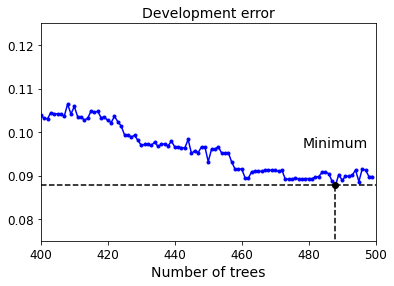

In [64]:
min_error = np.min(errors)

plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([400, 500], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.1, "Minimum", ha="center", fontsize=14)
plt.axis([400, 500, 0.075, 0.125])
plt.xlabel("Number of trees")
plt.title("Development error", fontsize=14)

plt.savefig('grad-boost-error.png')
plt.show()

In [65]:
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9093581431438527
Development set accuracy: 0.9113006110253139


Gradient boosting classifier gives a slightly lower accuracy than AdaBoost. Since there is a trade-off between `learning_rate` and `n_estimators`, There is no need to apply hyperparameter tuning on `learning_rate`, now that the best value for `n_estimators` has been found. Now I will apply hyperparameter tuning on `max_depth`:

In [66]:
gb_clf_best = GradientBoostingClassifier(max_depth=2, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.8030410421314154
Development set accuracy: 0.80588195796683


In [67]:
gb_clf_best = GradientBoostingClassifier(max_depth=4, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9317033864794491
Development set accuracy: 0.933928691331498


In [68]:
gb_clf_best = GradientBoostingClassifier(max_depth=5, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9360754441070482
Development set accuracy: 0.933660108775935


In [69]:
gb_clf_best = GradientBoostingClassifier(max_depth=6, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.941402490431461
Development set accuracy: 0.9317128852481031


In [70]:
gb_clf_best = GradientBoostingClassifier(max_depth=7, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9482067848962569
Development set accuracy: 0.9309071375814141


Based on the hyperparameter tuning results, the gradient boosting classifier's performance peaks when `max_depth=5`, and when `max_depth` gets greater than 5, overfitting may have occured.

In [71]:
gb_clf_best = GradientBoostingClassifier(max_depth=5, n_estimators=best_n_estimators, random_state=42)
gb_clf_best.fit(X_train_2_scaled, y_train)
y_train_pred = gb_clf_best.predict(X_train_2_scaled)
print('Training set accuracy:', accuracy_score(y_train, y_train_pred))
y_dev_pred = gb_clf_best.predict(X_dev_2_scaled)
print("Development set accuracy:",accuracy_score(y_dev, y_dev_pred))

Training set accuracy: 0.9360754441070482
Development set accuracy: 0.933660108775935


## 2.4 Deep Learning Models

Since this task is not a image recognition like problem, or a problem that requires processing on a sequence of input, I will not try convolutional neural networks or recurrent neural networks on this task, and will stick to the regular deep neural networks.

First I will start with the neural networks that I have built in the Practical 4 assignment. In order to find the optimal stopping point, I will deliberately start with an exaggerated number of epochs, forcing it to overfit:

In [72]:
tf.keras.backend.clear_session()

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(8,), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = dnn_model.fit(X_train_2_scaled, y_train - 1, batch_size=100, epochs=200, 
                        validation_data=(X_dev_2_scaled, y_dev - 1))

eval_train = dnn_model.evaluate(X_train_2_scaled, y_train - 1)
print('final training loss:', eval_train[0])
print('final training accuracy:', eval_train[1])
eval_dev = dnn_model.evaluate(X_dev_2_scaled, y_dev - 1)
print('final dev loss:', eval_dev[0])
print('final dev accuracy:', eval_dev[1])

Epoch 1/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.3670 - accuracy: 0.8133 - val_loss: 0.2130 - val_accuracy: 0.9090
Epoch 2/200
1341/1341 [==============================] - 1s 990us/step - loss: 0.1710 - accuracy: 0.9119 - val_loss: 0.1437 - val_accuracy: 0.9260
Epoch 3/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1441 - accuracy: 0.9211 - val_loss: 0.1307 - val_accuracy: 0.9286
Epoch 4/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1384 - accuracy: 0.9228 - val_loss: 0.1392 - val_accuracy: 0.9166
Epoch 5/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1341 - accuracy: 0.9236 - val_loss: 0.1339 - val_accuracy: 0.9221
Epoch 6/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1331 - accuracy: 0.9234 - val_loss: 0.1328 - val_accuracy: 0.9222
Epoch 7/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1310 - accuracy: 0.9237 - val_loss: 0.1224 - val_

1341/1341 [==============================] - 1s 1ms/step - loss: 0.1183 - accuracy: 0.9310 - val_loss: 0.1179 - val_accuracy: 0.9340
Epoch 114/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1178 - accuracy: 0.9312 - val_loss: 0.1203 - val_accuracy: 0.9329
Epoch 115/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1178 - accuracy: 0.9312 - val_loss: 0.1170 - val_accuracy: 0.9314
Epoch 116/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1187 - accuracy: 0.9309 - val_loss: 0.1172 - val_accuracy: 0.9337
Epoch 117/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1182 - accuracy: 0.9311 - val_loss: 0.1176 - val_accuracy: 0.9340
Epoch 118/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1181 - accuracy: 0.9312 - val_loss: 0.1176 - val_accuracy: 0.9339
Epoch 119/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1185 - accuracy: 0.9309 - val_loss: 0.1175 - val_ac

Epoch 169/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1175 - accuracy: 0.9314 - val_loss: 0.1171 - val_accuracy: 0.9332
Epoch 170/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1183 - accuracy: 0.9311 - val_loss: 0.1170 - val_accuracy: 0.9335
Epoch 171/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1176 - accuracy: 0.9311 - val_loss: 0.1171 - val_accuracy: 0.9333
Epoch 172/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1179 - accuracy: 0.9312 - val_loss: 0.1174 - val_accuracy: 0.9310
Epoch 173/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1177 - accuracy: 0.9315 - val_loss: 0.1184 - val_accuracy: 0.9327
Epoch 174/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1185 - accuracy: 0.9315 - val_loss: 0.1181 - val_accuracy: 0.9338
Epoch 175/200
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1176 - accuracy: 0.9313 - val_loss: 0

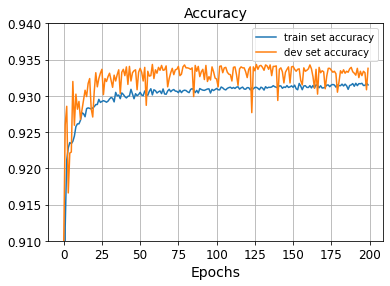

In [73]:
df = pd.DataFrame(history.history)
plt.plot(df['accuracy'], label='train set accuracy')
plt.plot(df['val_accuracy'], label='dev set accuracy')
plt.grid(True)
plt.gca().set_ylim(0.91, 0.94)
plt.xlabel('Epochs')
plt.title('Accuracy', fontsize=14)
plt.legend()

plt.savefig('dnn-accuracy-1.png')
plt.show()

It seems to peak at `epochs=150`:

In [74]:
tf.keras.backend.clear_session()

dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(8,), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = dnn_model.fit(X_train_2_scaled, y_train - 1, batch_size=100, epochs=150, 
                        validation_data=(X_dev_2_scaled, y_dev - 1))

eval_train = dnn_model.evaluate(X_train_2_scaled, y_train - 1)
print('final training loss:', eval_train[0])
print('final training accuracy:', eval_train[1])
eval_dev = dnn_model.evaluate(X_dev_2_scaled, y_dev - 1)
print('final dev loss:', eval_dev[0])
print('final dev accuracy:', eval_dev[1])

Epoch 1/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.3593 - accuracy: 0.8160 - val_loss: 0.2055 - val_accuracy: 0.9139
Epoch 2/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1694 - accuracy: 0.9125 - val_loss: 0.1427 - val_accuracy: 0.9243
Epoch 3/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1420 - accuracy: 0.9226 - val_loss: 0.1272 - val_accuracy: 0.9306
Epoch 4/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1365 - accuracy: 0.9229 - val_loss: 0.1366 - val_accuracy: 0.9282
Epoch 5/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1317 - accuracy: 0.9239 - val_loss: 0.1292 - val_accuracy: 0.9240
Epoch 6/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1296 - accuracy: 0.9246 - val_loss: 0.1270 - val_accuracy: 0.9316
Epoch 7/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1282 - accuracy: 0.9243 - val_loss: 0.1291 - val_ac

1341/1341 [==============================] - 2s 1ms/step - loss: 0.1183 - accuracy: 0.9311 - val_loss: 0.1171 - val_accuracy: 0.9342
Epoch 114/150
1341/1341 [==============================] - 1s 1ms/step - loss: 0.1180 - accuracy: 0.9313 - val_loss: 0.1175 - val_accuracy: 0.9339
Epoch 115/150
1341/1341 [==============================] - 2s 1ms/step - loss: 0.1181 - accuracy: 0.9315 - val_loss: 0.1170 - val_accuracy: 0.9333
Epoch 116/150
1341/1341 [==============================] - 2s 1ms/step - loss: 0.1187 - accuracy: 0.9311 - val_loss: 0.1172 - val_accuracy: 0.9343
Epoch 117/150
1341/1341 [==============================] - 2s 1ms/step - loss: 0.1179 - accuracy: 0.9314 - val_loss: 0.1173 - val_accuracy: 0.9333
Epoch 118/150
1341/1341 [==============================] - 2s 1ms/step - loss: 0.1187 - accuracy: 0.9311 - val_loss: 0.1204 - val_accuracy: 0.9334
Epoch 119/150
1341/1341 [==============================] - 2s 1ms/step - loss: 0.1183 - accuracy: 0.9314 - val_loss: 0.1172 - val_ac

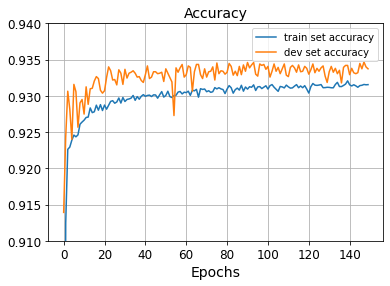

In [75]:
df = pd.DataFrame(history.history)
plt.plot(df['accuracy'], label='train set accuracy')
plt.plot(df['val_accuracy'], label='dev set accuracy')
plt.grid(True)
plt.gca().set_ylim(0.91, 0.94)
plt.xlabel('Epochs')
plt.title('Accuracy', fontsize=14)
plt.legend()

plt.savefig('dnn-accuracy-2.png')
plt.show()

Another top-level result obtained! (In fact, the neural network model has achieved the highest development set accuracy among all models by far!)

# 3 Evaluation

Firstly, I will evaluate the models on the test set. For those models trained using multiple dataset, I will only evaluate the model trained using the scaled second dataset, as this gives the best performance, and is the only dataset used in the later models. And for the Naïve Bayes models, I will only evaluate the `GaussianNB` model, as it performs best among all the Naïve Bayes models:

In [76]:
classifiers = [
    gnb_2_scaled, log_reg_2_scaled, sgd_2_scaled, hard_voting_clf, soft_voting_clf, 
    bag_clf, paste_clf, rnd_clf, ada_clf, gb_clf 
]

print('Accuracies on the test set:')
for clf in classifiers:
    y_test_pred = clf.predict(X_test_2_scaled)
    if clf == hard_voting_clf:
        print(clf.__class__.__name__, '(Hard voting)', accuracy_score(y_test, y_test_pred))
    elif clf == soft_voting_clf:
        print(clf.__class__.__name__, '(Soft voting)', accuracy_score(y_test, y_test_pred))
    elif clf == bag_clf:
        print(clf.__class__.__name__, '(Bagging)', accuracy_score(y_test, y_test_pred))
    elif clf == paste_clf:
        print(clf.__class__.__name__, '(Pasting)', accuracy_score(y_test, y_test_pred))
    else:
        print(clf.__class__.__name__, accuracy_score(y_test, y_test_pred))

Accuracies on the test set:
GaussianNB 0.5785593425187334
LogisticRegression 0.560188542422045
SGDClassifier 0.53535170413343
VotingClassifier (Hard voting) 0.5713077109016196
VotingClassifier (Soft voting) 0.5534203529127387
BaggingClassifier (Bagging) 0.7932076383853034
BaggingClassifier (Pasting) 0.7941140923374426
RandomForestClassifier 0.9213802272177907
AdaBoostClassifier 0.9190234469422287
GradientBoostingClassifier 0.9101401982112642


In [77]:
eval_test = dnn_model.evaluate(X_test_2_scaled, y_test - 1)
print('Neural network final test set accuracy:', eval_dev[1])

518/518 [==============================] - 0s 676us/step - loss: 0.1202 - accuracy: 0.9288
Neural network final test set accuracy: 0.9337272644042969


The neural network model gives the best test set accuracy. Now I will output the confusion matrix of this model, and the accuracy, precision, recall and F1 scores:

In [78]:
predictions = dnn_model.predict(X_test_2_scaled)
result = tf.argmax(predictions, axis=1)
conf_mx = tf.math.confusion_matrix(y_test - 1, result.numpy()).numpy()
conf_mx

array([[7866,  608],
       [ 570, 7504]])

In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test - 1, result.numpy()))
print('Precision:', precision_score(y_test - 1, result.numpy(), average='weighted', zero_division=0))
print('Recall:', recall_score(y_test - 1, result.numpy(), average='weighted'))
print('F1 score:', f1_score(y_test - 1, result.numpy(), average='weighted'))

Accuracy: 0.9288131496253323
Precision: 0.9288301038593892
Recall: 0.9288131496253323
F1 score: 0.9288167273655401


Looks like the model performs evenly well on both classes. Unfortunately, since there is no direct way to measure the feature importance in a neural network, I will output the feature importance of the random forest classifier, which performs nearly as well as the neural network model, and the feature importance derived from the random forest classifier can also be a very good reference:

In [80]:
for name, score in zip(data_2, rnd_clf.feature_importances_):
    print(name, score)

day 0.04735260862482614
order 0.0525012923504621
country 0.01324351456183027
page 1 (main category) 0.1368484462893777
colour 0.3373598005695257
location 0.22352617657130833
model photography 0.043362574626599995
page 0.14580558640606978


Therefore the colour of the product, `colour`, is the most important feature for predicting `price 2`. Following that, the photo location on the webpage, `location`, page number within the e-store website, `page`, and the main product category, `page 1 (main category)`, are also very important features for predicting `price 2`, compared to the other features.

# 4 Visualisation and Dimensionality Reduction

First, plot a splom on the unscaled second dataset to gain initial insights for further dimensionality reduction:

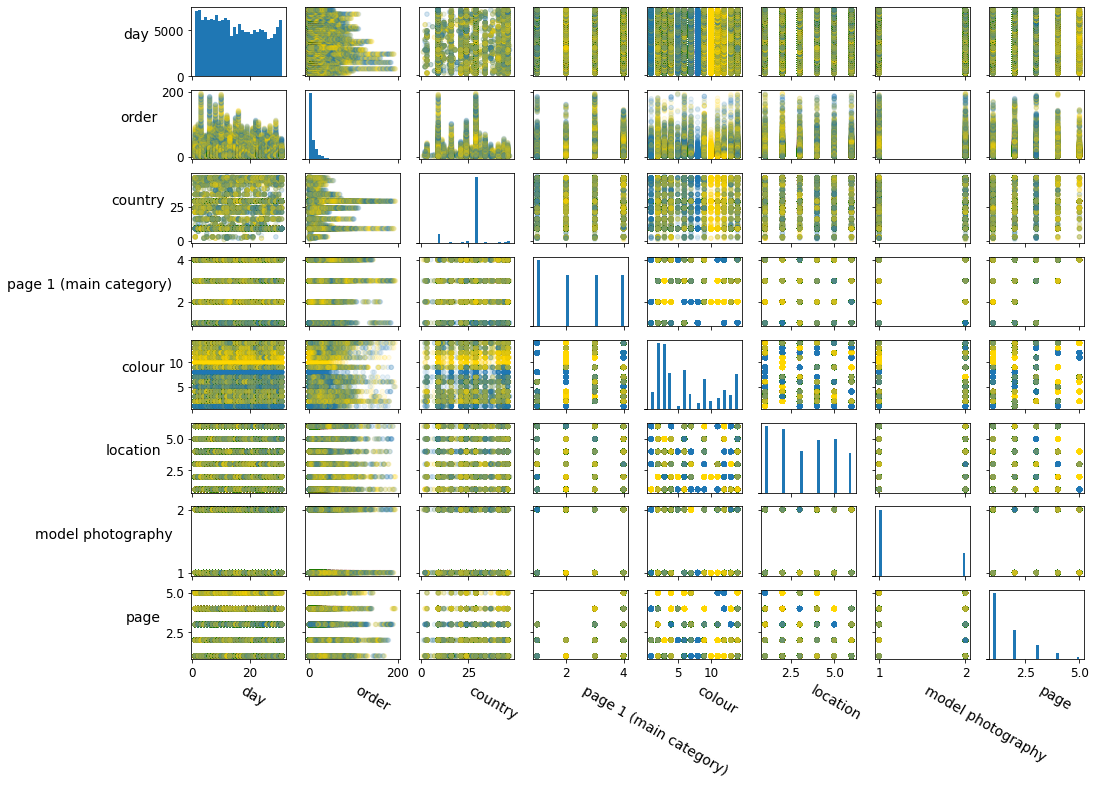

In [81]:
with plt.rc_context({'figure.figsize': (16, 12)}):
    fig, ax = plt.subplots(X_2.shape[1], X_2.shape[1], sharex='col', sharey='row')

cdict = ['gold', 'tab:blue']

# I will plot histograms on the diagonal, so they shouldn't share y-axis with the scatter plots
for i in range(X_2.shape[1]):
    ax[i, i].get_shared_y_axes().remove(ax[i, i])

# Plot histograms or scatter plots as appropriate
for i, row in enumerate(data_2):
    for j, col in enumerate(data_2):
        if i == j:
            ax[i, j].hist(eshop[col], bins=30)
        else:
            ax[i, j].scatter(eshop[col], eshop[row], s=20, c=np.take(cdict, (eshop['price 2'] - 1).values), alpha=.1)

# Rotate tick labels to make them legible
for i, row in enumerate(data_2):
    ax[i, 0].set_ylabel(row, rotation=0, ha='right')
for j, col in enumerate(data_2):
    ax[X_2.shape[1] - 1, j].set_xlabel(col, rotation=-30, ha='left')

plt.savefig('splom.png')
plt.show()

It shows on the splom that there is indeed a notable split on the `colour` attribute, which validates the feature importance obtained from the previous section.

Now apply full principal components analysis (PCA) on the scaled second dataset, and plot a scatter plot of the first two components, which represent the 2 most important features, `colour` and `location`: 

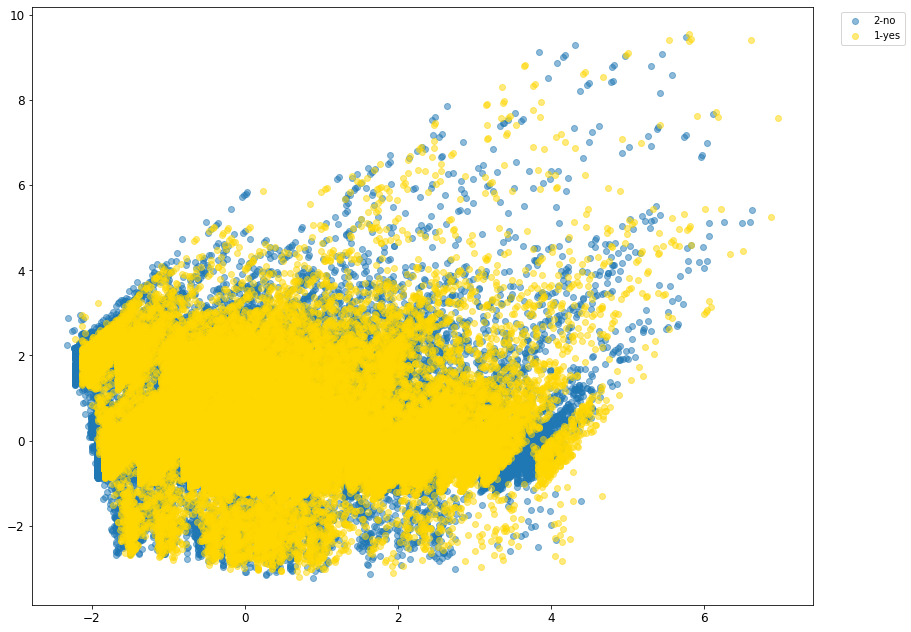

In [82]:
from sklearn.decomposition import PCA

pca = PCA()
pca_result = pca.fit_transform(X_2_scaled)

p1, p2 = pca_result[:,0], pca_result[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in eshop['price 2'].unique():
    i = (eshop['price 2'] == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

plt.savefig('pca.png')
plt.show()

Now apply t-SNE on the scaled second dataset, also letting it produce 2 components. Since t-SNE is slow, I will run t-SNE only on the test set which has only 16548 rows, rather than using the full dataset, in order to save time:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16548 samples in 0.104s...
[t-SNE] Computed neighbors for 16548 samples in 3.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16548
[t-SNE] Computed conditional probabilities for sample 2000 / 16548
[t-SNE] Computed conditional probabilities for sample 3000 / 16548
[t-SNE] Computed conditional probabilities for sample 4000 / 16548
[t-SNE] Computed conditional probabilities for sample 5000 / 16548
[t-SNE] Computed conditional probabilities for sample 6000 / 16548
[t-SNE] Computed conditional probabilities for sample 7000 / 16548
[t-SNE] Computed conditional probabilities for sample 8000 / 16548
[t-SNE] Computed conditional probabilities for sample 9000 / 16548
[t-SNE] Computed conditional probabilities for sample 10000 / 16548
[t-SNE] Computed conditional probabilities for sample 11000 / 16548
[t-SNE] Computed conditional probabilities for sample 12000 / 16548
[t-SNE] Computed conditional probabilities for sam

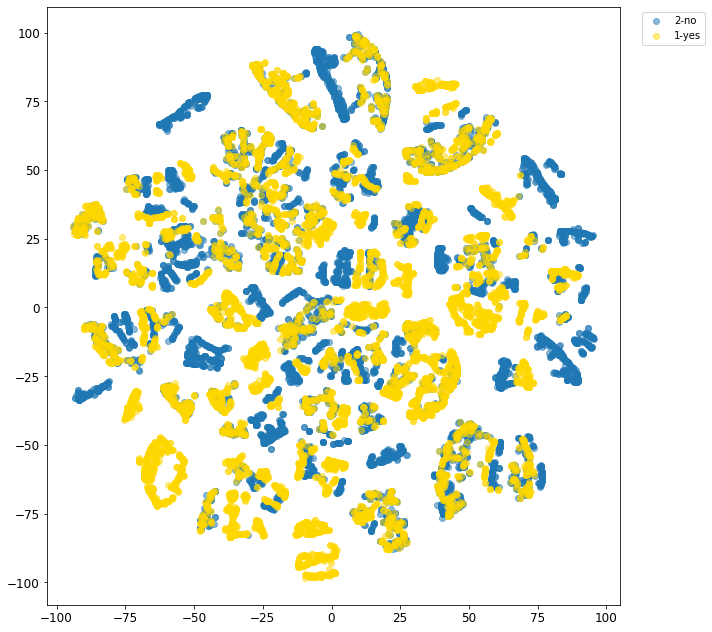

In [83]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X_test_2_scaled)

p1, p2 = tsne_results[:,0], tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in y_test.unique():
    i = (y_test == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')

plt.savefig('tsne-30.png')
plt.show()

Now try with different perplexities:

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 16548 samples in 0.114s...
[t-SNE] Computed neighbors for 16548 samples in 1.538s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16548
[t-SNE] Computed conditional probabilities for sample 2000 / 16548
[t-SNE] Computed conditional probabilities for sample 3000 / 16548
[t-SNE] Computed conditional probabilities for sample 4000 / 16548
[t-SNE] Computed conditional probabilities for sample 5000 / 16548
[t-SNE] Computed conditional probabilities for sample 6000 / 16548
[t-SNE] Computed conditional probabilities for sample 7000 / 16548
[t-SNE] Computed conditional probabilities for sample 8000 / 16548
[t-SNE] Computed conditional probabilities for sample 9000 / 16548
[t-SNE] Computed conditional probabilities for sample 10000 / 16548
[t-SNE] Computed conditional probabilities for sample 11000 / 16548
[t-SNE] Computed conditional probabilities for sample 12000 / 16548
[t-SNE] Computed conditional probabilities for sam

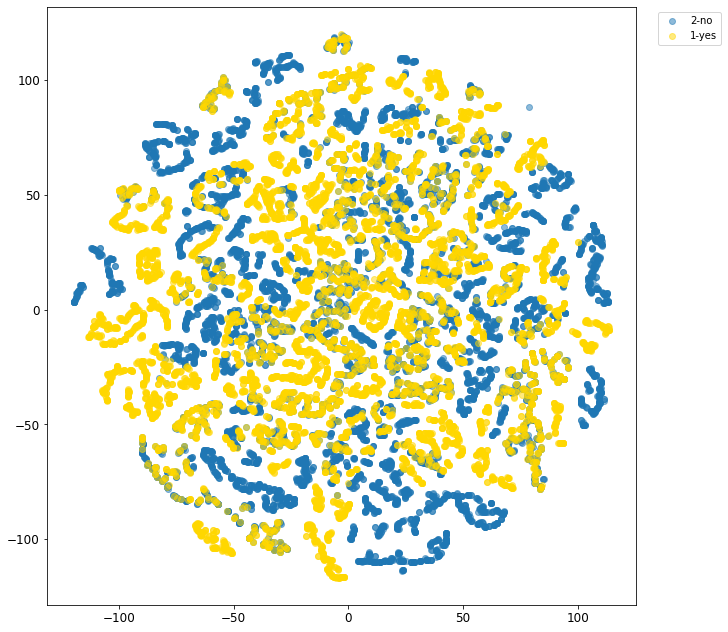

In [84]:
tsne = TSNE(n_components=2, perplexity=10, verbose=1)
tsne_results = tsne.fit_transform(X_test_2_scaled)

p1, p2 = tsne_results[:,0], tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in y_test.unique():
    i = (y_test == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')

plt.savefig('tsne-10.png')
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 16548 samples in 0.095s...
[t-SNE] Computed neighbors for 16548 samples in 1.996s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16548
[t-SNE] Computed conditional probabilities for sample 2000 / 16548
[t-SNE] Computed conditional probabilities for sample 3000 / 16548
[t-SNE] Computed conditional probabilities for sample 4000 / 16548
[t-SNE] Computed conditional probabilities for sample 5000 / 16548
[t-SNE] Computed conditional probabilities for sample 6000 / 16548
[t-SNE] Computed conditional probabilities for sample 7000 / 16548
[t-SNE] Computed conditional probabilities for sample 8000 / 16548
[t-SNE] Computed conditional probabilities for sample 9000 / 16548
[t-SNE] Computed conditional probabilities for sample 10000 / 16548
[t-SNE] Computed conditional probabilities for sample 11000 / 16548
[t-SNE] Computed conditional probabilities for sample 12000 / 16548
[t-SNE] Computed conditional probabilities for sam

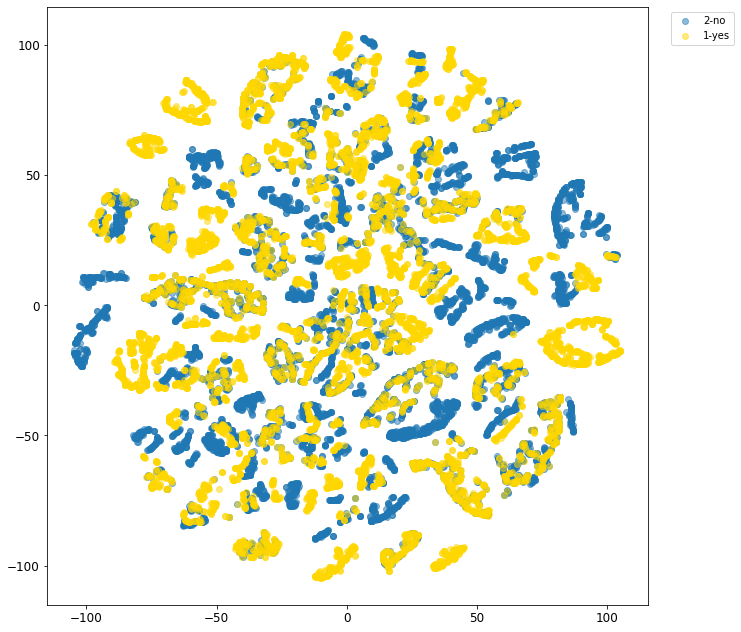

In [85]:
tsne = TSNE(n_components=2, perplexity=20, verbose=1)
tsne_results = tsne.fit_transform(X_test_2_scaled)

p1, p2 = tsne_results[:,0], tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in y_test.unique():
    i = (y_test == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')

plt.savefig('tsne-20.png')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16548 samples in 0.107s...
[t-SNE] Computed neighbors for 16548 samples in 2.833s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16548
[t-SNE] Computed conditional probabilities for sample 2000 / 16548
[t-SNE] Computed conditional probabilities for sample 3000 / 16548
[t-SNE] Computed conditional probabilities for sample 4000 / 16548
[t-SNE] Computed conditional probabilities for sample 5000 / 16548
[t-SNE] Computed conditional probabilities for sample 6000 / 16548
[t-SNE] Computed conditional probabilities for sample 7000 / 16548
[t-SNE] Computed conditional probabilities for sample 8000 / 16548
[t-SNE] Computed conditional probabilities for sample 9000 / 16548
[t-SNE] Computed conditional probabilities for sample 10000 / 16548
[t-SNE] Computed conditional probabilities for sample 11000 / 16548
[t-SNE] Computed conditional probabilities for sample 12000 / 16548
[t-SNE] Computed conditional probabilities for sa

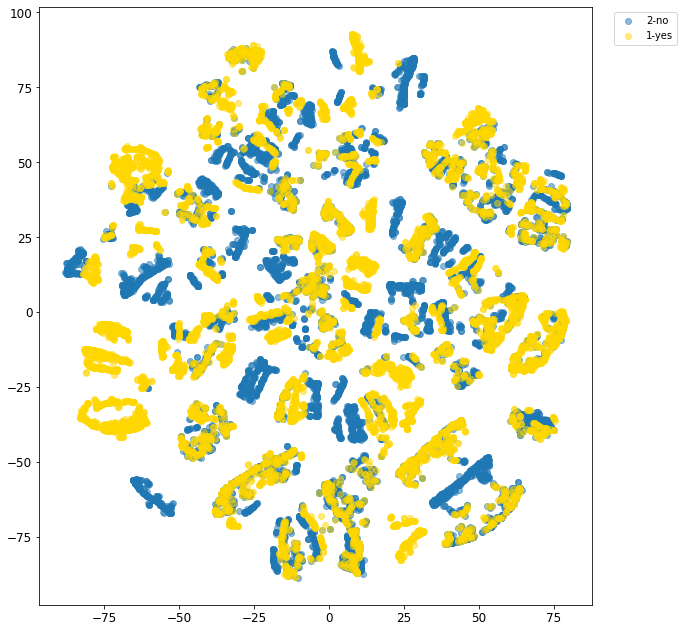

In [86]:
tsne = TSNE(n_components=2, perplexity=40, verbose=1)
tsne_results = tsne.fit_transform(X_test_2_scaled)

p1, p2 = tsne_results[:,0], tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in y_test.unique():
    i = (y_test == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')

plt.savefig('tsne-40.png')
plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 16548 samples in 0.103s...
[t-SNE] Computed neighbors for 16548 samples in 3.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16548
[t-SNE] Computed conditional probabilities for sample 2000 / 16548
[t-SNE] Computed conditional probabilities for sample 3000 / 16548
[t-SNE] Computed conditional probabilities for sample 4000 / 16548
[t-SNE] Computed conditional probabilities for sample 5000 / 16548
[t-SNE] Computed conditional probabilities for sample 6000 / 16548
[t-SNE] Computed conditional probabilities for sample 7000 / 16548
[t-SNE] Computed conditional probabilities for sample 8000 / 16548
[t-SNE] Computed conditional probabilities for sample 9000 / 16548
[t-SNE] Computed conditional probabilities for sample 10000 / 16548
[t-SNE] Computed conditional probabilities for sample 11000 / 16548
[t-SNE] Computed conditional probabilities for sample 12000 / 16548
[t-SNE] Computed conditional probabilities for sa

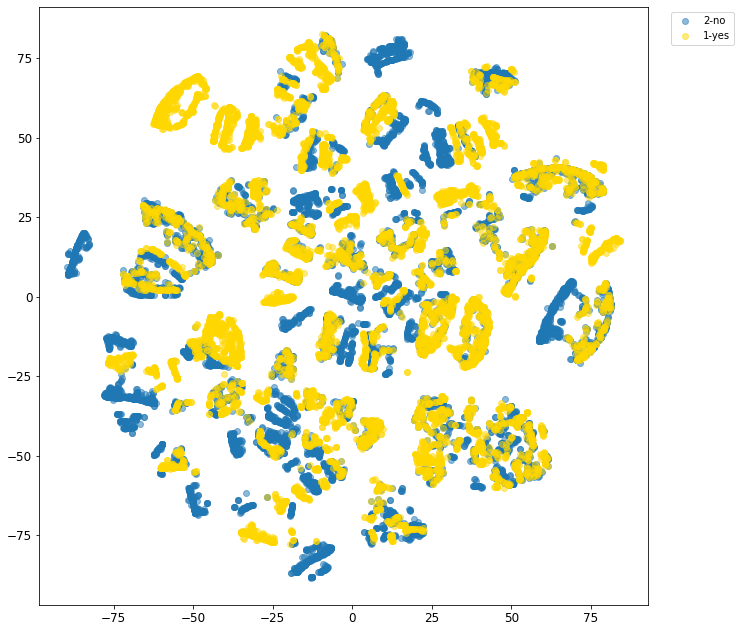

In [87]:
tsne = TSNE(n_components=2, perplexity=50, verbose=1)
tsne_results = tsne.fit_transform(X_test_2_scaled)

p1, p2 = tsne_results[:,0], tsne_results[:,1]

fig, ax = plt.subplots(figsize=(14, 11))
for val in y_test.unique():
    i = (y_test == val)
    if val == 1:
        plt.scatter(p1[i], p2[i], c='gold', label='1-yes', alpha=.5)
    else:
        plt.scatter(p1[i], p2[i], c='tab:blue', label='2-no', alpha=.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')

plt.savefig('tsne-50.png')
plt.show()

Conclusions driven from the visulisations:

- In PCA, the scatters of the 2 classes almost overlap with each other and do not provide helpful clustering for this task, whereas t-SNE can produce a more helpful clustering;
- As perplexity goes up, the clustering effect becomes more and more notable, and there are less overlapping. This suggests that a higher perplexity can help more in the visualisation of this task, using t-SNE;
- There are still overlaps even when I set the perplexity to 50, which suggests that the 2 most important features alone cannot perfectly separate the two classes, and would have to rely on more features.